# MODEL CUSTOMER SEGMENTATION

In [15]:
# Library
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

## DATA

In [5]:
# Load data
df = pd.read_excel("data.xlsx")

In [6]:
# In thử 10 dòng đầu tiên
df.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047.0,United Kingdom


In [7]:
# Xem thông tin df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [9]:
# Loại bỏ giá trị nan
df_not_nan = df[df.CustomerID.notna()]
df_not_nan.info()

<class 'pandas.core.frame.DataFrame'>
Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      406829 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.9+ MB


In [ ]:
# Tính toán RFM

# Tính R - Rencency: Mua hàng lâu hay gần
df_not_nan.InvoiceDate = pd.to_datetime(df_not_nan.InvoiceDate, format='%Y-%m-%d %H:%M:%S')

# Lấy ngày lớn nhất trong InvoiceDate trừ đi các ngày
current_date = max(df_not_nan.InvoiceDate) + datetime.timedelta(days=1)

# Tính M - MoneyTaryValue: tiền khách hàng bỏ ra
df_not_nan['TotalPay'] = df_not_nan['Quantity'] * df_not_nan['UnitPrice']

# Group by CustomerId để tính R, P, M
df_customers = df_not_nan.groupby(['CustomerID']).agg({
    'InvoiceDate': lambda x: (current_date - x.max()).days,
    'InvoiceNo': 'count',
    'TotalPay': 'sum'
})

In [22]:
df_customers.head()

,InvoiceDate,InvoiceNo,TotalPay
CustomerID,,,
12346.0,326,2,0.00
12347.0,3,182,4310.00
12348.0,76,31,1797.24
12349.0,19,73,1757.55
12350.0,311,17,334.40


In [25]:
df_customers.rename(columns={'InvoiceDate': 'Recency', 'InvoiceNo': 'Frequency','TotalPay': 'MoneyTaryValue'}, inplace=True)
df_customers

,Recency,Frequency,MoneyTaryValue
CustomerID,,,
12346.0,326,2,0.00
12347.0,3,182,4310.00
12348.0,76,31,1797.24
12349.0,19,73,1757.55
12350.0,311,17,334.40
...,...,...,...
18280.0,278,10,180.60
18281.0,181,7,80.82
18282.0,8,13,176.60


<Axes: xlabel='MoneyTaryValue', ylabel='Density'>

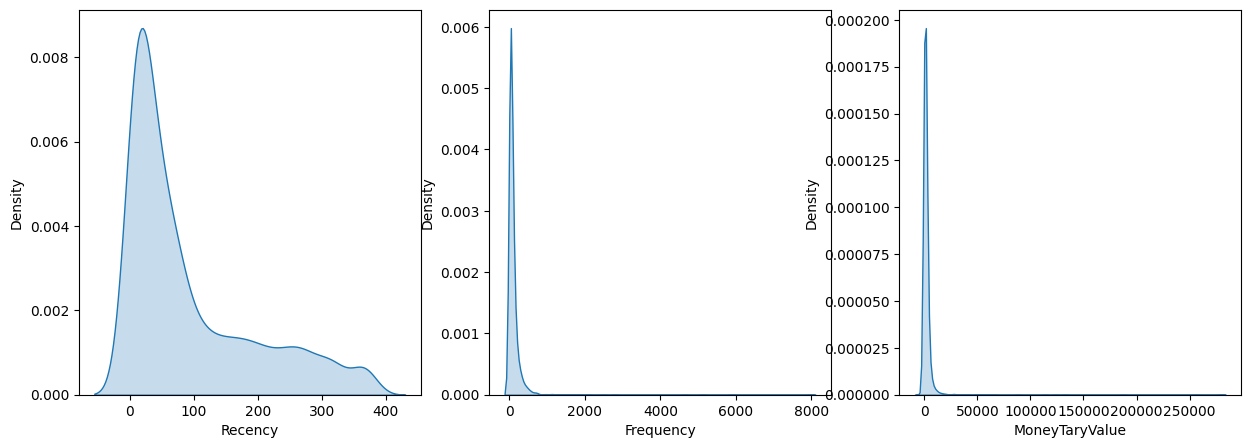

In [32]:
# Vẽ phân phối dữ liệu
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.kdeplot(df_customers['Recency'], ax=ax[0], fill=True)
sns.kdeplot(df_customers['Frequency'], ax=ax[1], fill=True)
sns.kdeplot(df_customers['MoneyTaryValue'], ax=ax[2], fill=True)

In [34]:
# Hàm kiểm tra xem nên chọn cách nào để transform
from scipy import stats
def analyze_skewness(x):
    fig, ax = plt.subplots(2, 2, figsize=(5,5))
    sns.distplot(df_customers[x], ax=ax[0,0])
    sns.distplot(np.log(df_customers[x]), ax=ax[0,1])
    sns.distplot(np.sqrt(df_customers[x]), ax=ax[1,0])
    sns.distplot(stats.boxcox(df_customers[x])[0], ax=ax[1,1])
    plt.tight_layout()
    plt.show()

    print(df_customers[x].skew().round(2))
    print(np.log(df_customers[x]).skew().round(2))
    print(np.sqrt(df_customers[x]).skew().round(2))
    print(pd.Series(stats.boxcox(df_customers[x])[0]).skew().round(2))

C:\Users\asus\AppData\Local\Temp\ipykernel_8588\2787652298.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_customers[x], ax=ax[0,0])
C:\Users\asus\AppData\Local\Temp\ipykernel_8588\2787652298.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.log(df_customers[x]), ax=ax[0,1])
C:\Users

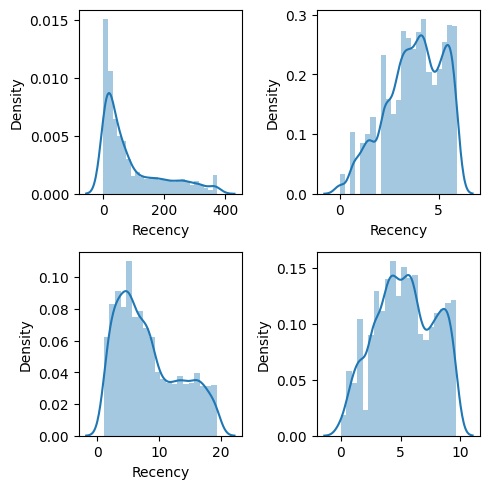

1.25
-0.45
0.6
-0.07


In [35]:
analyze_skewness('Recency')

C:\Users\asus\AppData\Local\Temp\ipykernel_8588\2787652298.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_customers[x], ax=ax[0,0])
C:\Users\asus\AppData\Local\Temp\ipykernel_8588\2787652298.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.log(df_customers[x]), ax=ax[0,1])
C:\Users

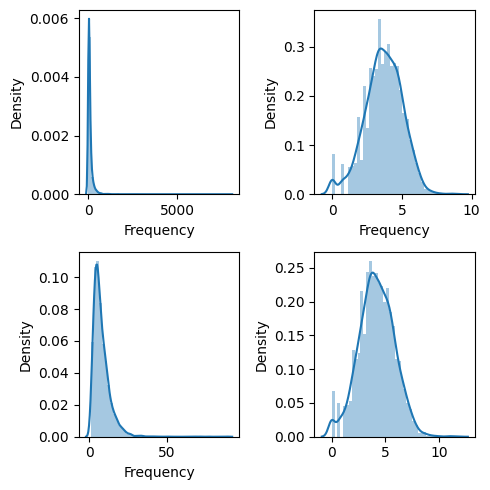

18.15
-0.24
3.2
0.0


In [36]:
analyze_skewness('Frequency')

In [40]:
# Tiến hành transform dữ liệu
df_customers_t = pd.DataFrame()
df_customers_t['Recency'] = stats.boxcox(df_customers['Recency'])[0]
df_customers_t['Frequency'] = stats.boxcox(df_customers['Frequency'])[0]
df_customers_t['MoneyTaryValue'] = pd.Series(np.cbrt(df_customers['MoneyTaryValue'])).values
df_customers_t.head(10)

,Recency,Frequency,MoneyTaryValue
0,9.314966,0.707055,0.000000
1,1.196521,6.060363,16.273929
2,6.146603,3.794006,12.158183
3,3.721132,4.862047,12.068017
4,9.201024,3.075409,6.941001
5,4.823034,5.201183,11.561510
6,8.227911,1.442672,4.464745
7,8.520247,4.570059,10.257955
8,8.335994,2.762414,7.716085
9,4.025584,4.591627,14.113750


In [41]:
# Tiến hành scale dữ liệu
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(df_customers_t)
df_customers_t_scaled = scaler.transform(df_customers_t)
pd.DataFrame(df_customers_t_scaled).head(10)

,0,1,2
0,1.606608,-2.098072,-1.925647
1,-1.696240,1.151346,1.330542
2,0.317615,-0.224316,0.507038
3,-0.669146,0.423978,0.488997
4,1.560253,-0.660498,-0.536848
5,-0.220856,0.629831,0.387652
6,1.164358,-1.651557,-1.032313
7,1.283290,0.246743,0.126828
8,1.208330,-0.850484,-0.381765
9,-0.545284,0.259835,0.898320


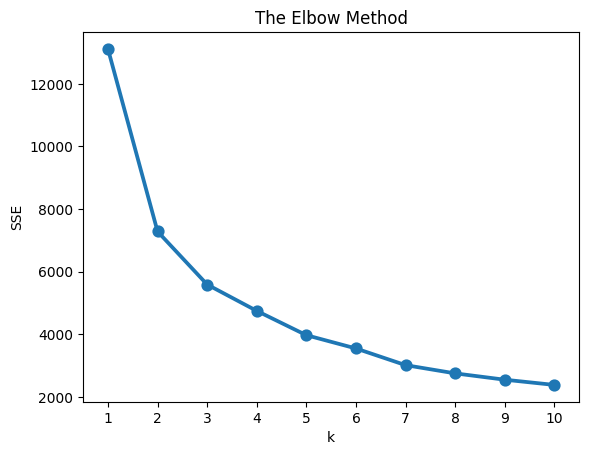

In [42]:
# Đưa dữ liệu vào KNN

from sklearn.cluster import KMeans

sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_customers_t_scaled)
    sse[k] = kmeans.inertia_

plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()